# ODE system

Solving the ODE system
$$
\begin{cases}
\frac{dy_1}{dt} &= y_2, \\
\frac{dy_2}{dt} &= -y_1,
\end{cases}
$$
where $t \in [0, 10]$ and with the initial conditions $y_1(0) = 0$ and $y_2(0) = 1$.

We know that the solution is $y_1(t) = \sin(t)$ and $y_2(t) = \cos(t)$.

In [9]:
import deepxde as dde
import numpy as np

Define the computational geometry using a time domain from 0 to 10.

In [10]:
geom = dde.geometry.TimeDomain(0, 10)

Define the ODE system.  
The first argument of ode_system is the independent variable t.  
The second argument is the dependent variable y, where y[:, 0] is the first component $y_1$ and y[:, 1] is the second component $y_2$.

In [11]:
def ode_system(x, y):
	y1, y2 = y[:, 0:1], y[:, 1:]
	dy1_x = dde.grad.jacobian(y, x, i=0)
	dy2_x = dde.grad.jacobian(y, x, i=1)
	return [dy1_x - y2, dy2_x + y1]

Define the boundary conditions.

Create a function that checks if a given point is inside the subdomain.

The first argument of the boundary condition is the network input x, that has the same dimension as the geometry (1D in this case).

We need to check if the input x is on the initial condition $t=0$. We could use the function dde.utils.isclose `dde.utils.isclose(x[0], 0)` to check if the input x is close to 0, but we can also use the argument `on_initial` that is True if the input x is on the initial condition and False otherwise.

In [12]:
def boundary(x, on_initial):
	# return dde.utils.isclose(x[0], 0)
	return on_initial

Define the initial conditions, `ic1` and `ic2`, for the first and second components, respectively.

In [13]:
ic1 = dde.icbc.IC(geom, lambda x: 0, boundary, component=0)
ic2 = dde.icbc.IC(geom, lambda x: 1, boundary, component=1)

Define the reference solution to compute the error of the network.

In [14]:
def func(x):
	return np.hstack((np.sin(x), np.cos(x)))

Define the ODE problem with `dde.data.PDE` since it's also a ODE solver.

We use 35 points inside the domain and 2 points on the boundary (the start and the end of the time domain). 

We use 100 points to calculate the residual error.

In [15]:
data = dde.data.PDE(geom, ode_system, [ic1, ic2], 35, 2, solution=func, num_test=100)

Define the network.

In [16]:
layer_size = [1] + [50] * 3 + [2]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

Define the model for the ODE problem.

In [17]:
model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])

Compiling model...
Building feed-forward neural network...
'build' took 0.034231 s

'compile' took 0.183780 s



Train the model.

In [18]:
loss_history, train_state = model.train(iterations=20000)

Training model...

Step      Train loss                                  Test loss                                   Test metric   
0         [1.80e-01, 1.37e-02, 0.00e+00, 1.00e+00]    [1.85e-01, 1.27e-02, 0.00e+00, 1.00e+00]    [1.13e+00]    


2024-09-08 11:36:35.227604: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled


1000      [7.55e-03, 6.41e-03, 1.16e-08, 2.58e-04]    [8.46e-03, 6.43e-03, 1.16e-08, 2.58e-04]    [7.47e-01]    
2000      [4.24e-03, 4.00e-03, 1.46e-06, 9.74e-05]    [4.39e-03, 4.20e-03, 1.46e-06, 9.74e-05]    [5.44e-01]    
3000      [2.23e-03, 2.87e-03, 1.57e-06, 4.29e-05]    [2.35e-03, 2.82e-03, 1.57e-06, 4.29e-05]    [3.96e-01]    
4000      [9.29e-04, 1.54e-03, 7.06e-07, 1.64e-05]    [9.82e-04, 1.39e-03, 7.06e-07, 1.64e-05]    [2.48e-01]    
5000      [1.85e-04, 2.30e-04, 6.15e-08, 2.36e-06]    [2.06e-04, 1.78e-04, 6.15e-08, 2.36e-06]    [9.05e-02]    
6000      [4.98e-05, 4.78e-05, 1.46e-08, 2.06e-07]    [4.90e-05, 3.56e-05, 1.46e-08, 2.06e-07]    [2.81e-02]    
7000      [2.25e-05, 2.34e-05, 9.27e-09, 3.91e-08]    [2.05e-05, 2.17e-05, 9.27e-09, 3.91e-08]    [1.15e-02]    
8000      [1.31e-05, 1.94e-05, 1.80e-08, 1.88e-07]    [1.22e-05, 1.90e-05, 1.80e-08, 1.88e-07]    [7.78e-03]    
9000      [3.95e-05, 3.27e-05, 4.84e-06, 9.09e-07]    [3.77e-05, 3.36e-05, 4.84e-06, 9.09e-07]  

Visualize the loss history and save the plots.

Saving loss history to /Users/giacomo/dev/notebooks/dde-playground/loss.dat ...
Saving training data to /Users/giacomo/dev/notebooks/dde-playground/train.dat ...
Saving test data to /Users/giacomo/dev/notebooks/dde-playground/test.dat ...


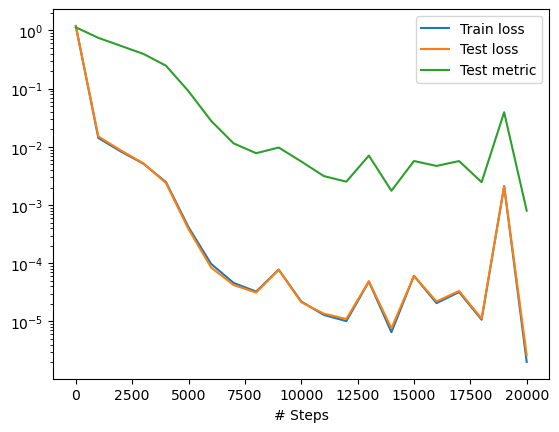

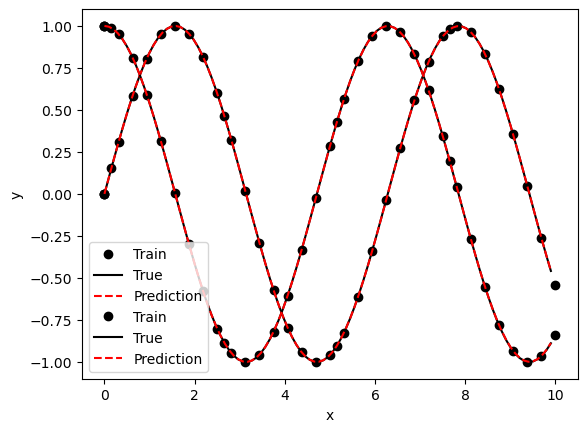

In [19]:
dde.saveplot(loss_history, train_state, issave=True, isplot=True)